In [84]:
!pip install -U scikit-learn scipy matplotlib
!pip install tensorflow
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate
from sklearn.inspection import permutation_importance
from numpy import mean, max, prod, array, hstack
from numpy.random import choice
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Dense, Dropout, Activation, BatchNormalization, LeakyReLU
from tensorflow.keras import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import plot_model
from tqdm import tqdm



[notice] A new release of pip is available: 23.3.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.3.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [87]:
def build_autoencoder(dim_input, dim_layer_1, dim_layer_2):
    
    input_layer = Input(shape=(dim_input,))
    x = Activation("relu")(input_layer)
    x = Dense(dim_layer_1)(x)
    x = Activation("relu")(x)
    bottleneck_layer = Dense(dim_layer_2)(x)
    x = Activation("relu")(bottleneck_layer)
    x = Dense(dim_layer_1)(x)
    x = Activation("relu")(x)    
    output_layer = Dense(dim_input, activation='linear')(x)
    
    encoder = Model(input_layer, bottleneck_layer)
    autoencoder = Model(input_layer, output_layer)
    autoencoder.compile(optimizer='adam', loss='mse')
    print(f"Autoencoder Input Dim: {dim_input}")
    print(f"Autoencoder Output Dim: {dim_layer_1}")
    print(f"Autoencoder Bottleneck Dim: {dim_layer_2}")
    
    return autoencoder, encoder

In [79]:
df = pd.read_csv("D:/Thoth project/datasets/CWRU bearing/CWRU_bearing.csv", sep=",")
df.columns = df.columns.str.replace('"', '').str.strip()
print(df.columns)
print(df.head())
feature_columns = ['max','min','mean','sd','rms','skewness','kurtosis','crest','form']
target_column = 'fault'
X = df[feature_columns]
y = df[target_column]
min_max_scaler = MinMaxScaler()
X = min_max_scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Index(['max', 'min', 'mean', 'sd', 'rms', 'skewness', 'kurtosis', 'crest',
       'form', 'fault'],
      dtype='object')
       max      min      mean        sd       rms  skewness  kurtosis   
0  0.35986 -0.41890  0.017840  0.122746  0.124006 -0.118571 -0.042219  \
1  0.46772 -0.36111  0.022255  0.132488  0.134312  0.174699 -0.081548   
2  0.46855 -0.43809  0.020470  0.149651  0.151008  0.040339 -0.274069   
3  0.58475 -0.54303  0.020960  0.157067  0.158422 -0.023266  0.134692   
4  0.44685 -0.57891  0.022167  0.138189  0.139922 -0.081534  0.402783   

      crest      form       fault  
0  2.901946  6.950855  Ball_007_1  
1  3.482334  6.035202  Ball_007_1  
2  3.102819  7.376926  Ball_007_1  
3  3.691097  7.558387  Ball_007_1  
4  3.193561  6.312085  Ball_007_1  


In [20]:
#Baseline performance on original data
rf = RandomForestClassifier(
    n_estimators=500, 
    max_depth=2, 
    n_jobs=8, 
    random_state=42
)
dict_performance = cross_validate(
    estimator=rf, 
    X=X, y=y, 
    cv=10, 
    n_jobs=4,
    return_train_score=True,
    scoring=[
        "balanced_accuracy", 
        "f1_weighted", 
        "roc_auc", 
        "average_precision"
    ]
)
df_performance = pd.DataFrame(
    {"ORIGINAL": [mean(dict_performance[k]) \
                  for k in dict_performance.keys()]}, 
    index=dict_performance.keys()
)
print(df_performance)


                         ORIGINAL
fit_time                 0.732199
score_time               0.150745
test_balanced_accuracy   0.793478
train_balanced_accuracy  0.797053
test_f1_weighted         0.746635
train_f1_weighted        0.752148
test_roc_auc                  NaN
train_roc_auc                 NaN
test_average_precision   0.807521
train_average_precision  0.806786


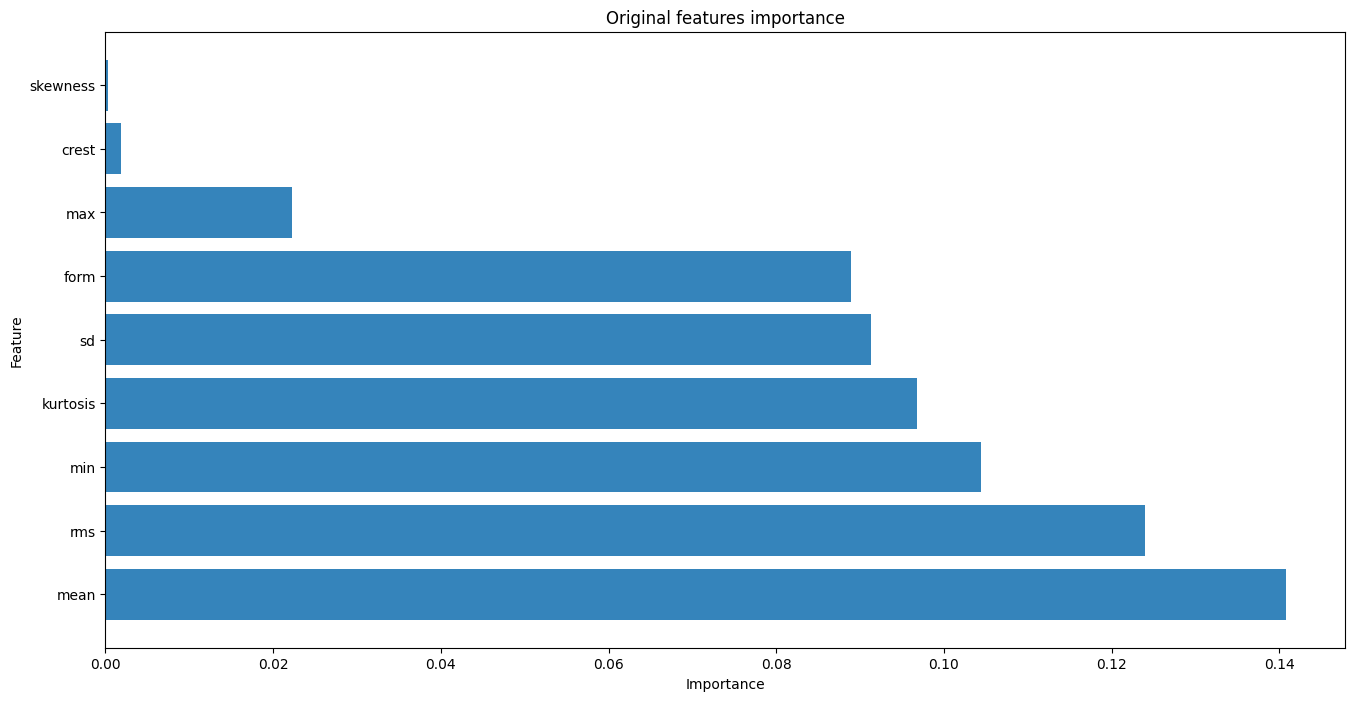

In [6]:
#plotting the importance of the features in order to understand which one affects the target variable.
rf = RandomForestClassifier(
    n_estimators=500, 
    max_depth=2, 
    n_jobs=8, 
    random_state=42
)
rf.fit(X, y)
fi = permutation_importance(
    estimator=rf, 
    X=X, 
    y=y, 
    n_repeats=10, 
    n_jobs=8, 
    random_state=42
).importances_mean

plt.figure(figsize=(16,8))
sorted_idx = fi.argsort()[::-1]
sorted_features = [feature_columns[i] for i in sorted_idx]
plt.barh(
    y=range(len(feature_columns)), 
    width=fi[sorted_idx], 
    alpha=0.9
)
plt.ylabel("Feature")
plt.yticks(
    range(len(feature_columns)), 
    sorted_features
)
plt.xlabel("Importance")
plt.title("Original features importance")
plt.show()

In [88]:
#building autoencoder
dim_layer_input = X.shape[1]
dim_layer_1 = max((int(3*dim_layer_input/4), 1))
dim_layer_2 = max((int(dim_layer_input/2), 1))
autoencoder, encoder = build_autoencoder(
    dim_input=dim_layer_input,
    dim_layer_1=dim_layer_1,
    dim_layer_2=dim_layer_2,   
)


Autoencoder Input Dim: 9
Autoencoder Output Dim: 6
Autoencoder Bottleneck Dim: 4


In [81]:
#Training the model 
callbacks = [
    EarlyStopping(monitor='val_loss', patience=20, verbose=1),
    ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, verbose=1)
]

autoencoder.fit(
    X_train, X_train,
    epochs=100,
    batch_size=256,
    shuffle=True,
    validation_data=(X_test, X_test),
    callbacks=callbacks
)

# Transform data
X_train_encoded = encoder.predict(X_train)
X_test_encoded = encoder.predict(X_test)
df_train_encoded = pd.DataFrame(X_train_encoded, columns=[f"encoded_{i+1}" for i in range(X_train_encoded.shape[1])])
df_test_encoded = pd.DataFrame(X_test_encoded, columns=[f"encoded_{i+1}" for i in range(X_test_encoded.shape[1])])
print(f"Encoded Train Shape: {X_train_encoded.shape}")
print(f"Encoded Test Shape: {X_test_encoded.shape}")

print("Anonymized Training Data:")
print(df_train_encoded.head())

print("\nAnonymized Testing Data:")
print(df_test_encoded.head())

Epoch 1/100
1/8 ━━━━━━━━━━━━━━━━━━━━ 4s 692ms/step - loss: 0.1404
Epoch 1: val_loss improved from inf to 0.12537, saving model to best_model.keras
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.1373 - val_loss: 0.1254
Epoch 2/100
1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.1239
Epoch 2: val_loss improved from 0.12537 to 0.11219, saving model to best_model.keras
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1222 - val_loss: 0.1122
Epoch 3/100
1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.1096
Epoch 3: val_loss improved from 0.11219 to 0.10106, saving model to best_model.keras
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1089 - val_loss: 0.1011
Epoch 4/100
1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.1005
Epoch 4: val_loss improved from 0.10106 to 0.09159, saving model to best_model.keras
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0987 - val_loss: 0.0916
Epoch 5/100
1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0925
Epoch 5: val_loss improved from 0.09159 to 0.08343, s

In [89]:
rf_classifier = RandomForestClassifier(n_estimators=500, max_depth=5, n_jobs=8, random_state=42)

dict_performance_original = cross_validate(
    estimator=rf_classifier,
    X=X_train, y=y_train,
    cv=10,
    n_jobs=4,
    return_train_score=True,
    scoring=["balanced_accuracy", "f1_weighted", "roc_auc", "average_precision"]
)
df_performance = pd.DataFrame(
    {"ORIGINAL": [mean(dict_performance_original[k]) for k in dict_performance_original.keys()]},
    index=dict_performance_original.keys()
)

dict_performance_encoded = cross_validate(
    estimator=rf_classifier,
    X=X_train_encoded, y=y_train,
    cv=10,
    n_jobs=4,
    return_train_score=True,
    scoring=["balanced_accuracy", "f1_weighted", "roc_auc", "average_precision"]
)
df_performance["ENCODED"] = [mean(dict_performance_encoded[k]) for k in dict_performance_encoded.keys()]

print(df_performance)

                         ORIGINAL   ENCODED
fit_time                 1.035198  0.963198
score_time               0.171200  0.181901
test_balanced_accuracy   0.938283  0.901054
train_balanced_accuracy  0.947683  0.924699
test_f1_weighted         0.939209  0.899925
train_f1_weighted        0.948957  0.924395
test_roc_auc                  NaN       NaN
train_roc_auc                 NaN       NaN
test_average_precision   0.969928  0.946033
train_average_precision  0.978222  0.962059


In [83]:
reconstruction_loss = autoencoder.evaluate(X_test, X_test)
print(f'Reconstruction Loss: {reconstruction_loss}')

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 658us/step - loss: 0.0069
Reconstruction Loss: 0.006746251601725817
